In [1]:
import numpy as np
import hnswlib
from numpy import linalg as LA

def cosine_sim(x,y):
    return np.dot(x,y)/LA.norm(x)/LA.norm(y)

class mol:
    def __init__(self,smiles0,smiles1,feat):
        self.smiles0=smiles0
        self.smiles1=smiles1
        self.feat=feat

class infogain:
    def __init__(self, initial_points=None, n=3000000, keep_seed=False, submodular_k=4):
        self.clusters = None
        self.target_n = n
        self.current_n = 0
        self.keep_seed = keep_seed
        self.dim = 2348*4
        self.submodular_k = submodular_k

        if initial_points: 
            self.data = initial_points.copy()
            self.current_n = len(initial_points)
            if keep_seed:
                self.seeded_num = len(initial_points)
            self.dim = len(initial_points[0].feat)
        else:
            self.data = []
        self.submodular_gain = [(1)]*len(self.data)
        # initialize HNSW index
        self.knn_graph = hnswlib.Index(space='cosine', dim=self.dim)
        self.knn_graph.init_index(max_elements=n, ef_construction=100, M=48, allow_replace_deleted = False)
        self.precluster(initial_points)
        self.knn_graph.set_ef(32)

    def precluster(self, initial_points):
    # Starting from some initial points (the cleaner the better) to do online selection
        if initial_points is None or initial_points==[]: return
        for idx,data in enumerate(self.data):
            data.index = idx

        for idx,data in enumerate(self.data):
            self.submodular_gain[idx] = self.submodular_func(data, True)
            self.knn_graph.add_items(data.feat, idx)

    def submodular_func(self, data, skip_one=False):
        if self.knn_graph.get_current_count()==0:
            return (1.)
        k = min(self.knn_graph.get_current_count(), self.submodular_k)
        near_label,near_distances = self.knn_graph.knn_query(data.feat, k)
        return np.mean(near_distances)

    def add_item(self, data):
        data.index = self.current_n
        self.data.append(data)
        self.knn_graph.add_items(data.feat, self.current_n)
        self.current_n+=1

    def replace_item(self, data, index):
        # Not used in current work but provide for future extension on replacing samples
        data_to_rep = self.data[index]
        n_index = data_to_rep.index
        data.index = self.current_n
        self.knn_graph.mark_deleted(n_index)
        self.knn_graph.add_items(data.I_feat, self.current_n, replace_deleted = True)
        self.data[index] = data
        self.current_n+=1

    def process_item(self, data,):
        # find near clusters
        # go into nearest clusters to search near neighbour
        # calculate corresponding threshold to decide if try to add or not
        gain = self.submodular_func(data)
        self.add_item(data)
        self.submodular_gain.append(gain)

    def final_gains(self):
        return self.submodular_gain


In [2]:
import torch
data = torch.load('/home/1739678401/2024.9dataclean/MMGNN_0901/temp_data/combined_features_with_smiles.pt')
# 提取 SMILES 列表和特征张量
smiles = data['smiles']
features = data['features']
dic={}
for i in range(len(smiles)):
    dic[smiles[i]]=features[i]
import pandas as pd
feats=[]
def file_to_mol(filepath):
    df = pd.read_csv(filepath, usecols=[0, 1])
    res=[]
    for i, row in df.iterrows():
        tensor1=dic[row[0]]
        tensor2=dic[row[1]]
        feat=torch.cat((tensor1,tensor1,tensor1, tensor2), dim=0).to(dtype=torch.float32).cpu().numpy()
        feats.append(feat)
        res.append(mol(row[0],row[1],feat))
    return res
filepath='/home/1739678401/2024.9dataclean/MMGNN_0901/data/exp_data.csv'
res=file_to_mol(filepath)
IG=infogain(res)
mn_finalgains=IG.final_gains()
print(len(mn_finalgains))
import numpy as np
gains = np.array([ (gain) for gain in mn_finalgains])

8780


In [3]:
def count_aromatic_atoms(mol):
    aromatic_atoms = 0
    for atom in mol.GetAtoms():
        if atom.GetIsAromatic():
            aromatic_atoms += 1
    return aromatic_atoms

In [4]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def classify_molecule(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"

    # 判断是否为水
    if smiles == "O":
        return "Water"

    # 判断是否存在分子内氢键
    h_bond_donors = rdMolDescriptors.CalcNumHBD(mol)
    h_bond_acceptors = rdMolDescriptors.CalcNumHBA(mol)
    if h_bond_donors > 0 and h_bond_acceptors > 0:
        return "Intra - molecular H - bonding"

    # 判断是否为醇或胺
    atom_numbers = mol.GetAtoms()
    for atom in atom_numbers:
        if atom.GetAtomicNum() == 8 and atom.GetTotalNumHs() > 0:  # 氧原子且有氢连接，可能是醇
            return "Alcohols & Amines"
        elif atom.GetAtomicNum() == 7 and atom.GetTotalNumHs() > 0:  # 氮原子且有氢连接，可能是胺
            return "Alcohols & Amines"

    # 判断是否为含O和N的化合物
    contains_o = any(atom.GetAtomicNum() == 8 for atom in atom_numbers)
    contains_n = any(atom.GetAtomicNum() == 7 for atom in atom_numbers)
    if contains_o and contains_n:
        return "O & N - containing"

    # 判断是否为卤代烃
    contains_halogen = any(atom.GetAtomicNum() in [9, 17, 35, 53] for atom in atom_numbers)
    if contains_halogen:
        return "Halogens"

    # 判断是否为芳香族化合物
    if count_aromatic_atoms(mol) > 0:
        return "Aromatics"

    # 判断是否为烃类
    contains_c = any(atom.GetAtomicNum() == 6 for atom in atom_numbers)
    contains_h = any(atom.GetAtomicNum() == 1 for atom in atom_numbers)
    if contains_c and contains_h and not contains_o and not contains_n and not contains_halogen:
        return "Hydrocarbons"

    return "Others"

Aromatics 604
Intra - molecular H - bonding 2590
Others 3150
Halogens 663
O & N - containing 620
Water 1153


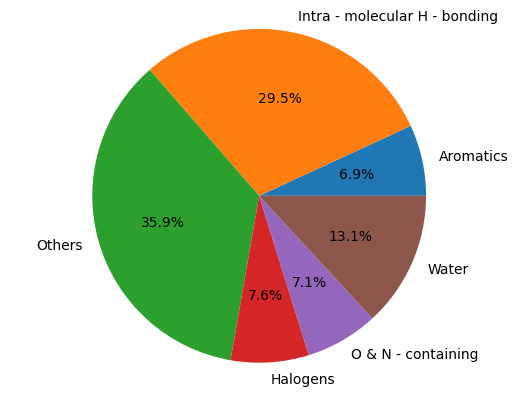

In [5]:
import csv
def process_csv(csv_file_path):
    result_dict = {}
    with open(csv_file_path, 'r', encoding='utf - 8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        np.random.seed(0)
        for idx, row in enumerate(reader):
            if len(row) > 0:
                smiles = row[0]
                category = classify_molecule(smiles)
                if category not in result_dict:
                    result_dict[category] = []
                result_dict[category].append(idx)
    return result_dict
res_dic=process_csv(filepath)
categories=[]
counts=[]
for category, indices in res_dic.items():
    print(category, len(indices))
    categories.append(category)
    counts.append(len(indices))
import matplotlib.pyplot as plt

plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.axis('equal')  
plt.savefig('no screen.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import csv
def process_csv(csv_file_path):
    result_dict = {}
    with open(csv_file_path, 'r', encoding='utf - 8') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for idx, row in enumerate(reader):
            if len(row) > 0:
                smiles = row[0]
                if gains[idx]>=0.3:
                    category = classify_molecule(smiles)
                    if category not in result_dict:
                        result_dict[category] = []
                    result_dict[category].append(idx)
    return result_dict
res_dic=process_csv(filepath)
categories=[]
counts=[]
for category, indices in res_dic.items():
    print(category, len(indices))
    categories.append(category)
    counts.append(len(indices))

import matplotlib.pyplot as plt


# 绘制饼状图
plt.pie(counts, labels=categories, autopct='%1.1f%%')
plt.axis('equal')  # 保证饼图是圆形
plt.savefig('screen.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import umap
import matplotlib.pyplot as plt
color_dict = {
    'Water': 'lightblue',
    'O & N - containing':  'lightgreen',
    'Intra - molecular H - bonding': 'lightgreen',
    'Aromatics': 'pink',
    'Others': 'lavender',
    'Halogens': 'tan'
}
darker_color_dict = {
    'Water': 'darkblue',
    'O & N - containing': 'darkgreen',
    'Intra - molecular H - bonding': 'darkgreen',
    'Aromatics': 'darkred',
    'Others': 'darkpurple',
    'Halogens': 'darkgoldenrod'
}

def plot_umap(csv_file_path,result, feats, num):
    # 读取CSV文件数据
    df = pd.read_csv(csv_file_path)
    smiles_list = df.iloc[:, 1].tolist()  # 获取第二列（分子SMILES表示）的数据列表

    # 用于记录已经出现过的分子的字典
    seen_molecules = {}
    all_feats = []
    labels = []
    count_per_category = {category: 0 for category in result.keys()}  # 记录每个类别已添加的数量
    for category, indices in result.items():
        if category!='Others' and category!= 'Intra - molecular H - bonding':
            for idx in indices:
                molecule_smiles = smiles_list[idx]
                if molecule_smiles not in seen_molecules and count_per_category[category] < num:
                    seen_molecules[molecule_smiles] = True
                    all_feats.append(feats[idx])
                    labels.append(category)
                    count_per_category[category] += 1

    # 将特征转换为numpy数组
    all_feats = np.array(all_feats)
    print(len(all_feats))
    # 使用UMAP进行降维
    reducer = umap.UMAP(n_neighbors = 30,min_dist = 1)
    embedding = reducer.fit_transform(all_feats)
    # 绘制降维图
    plt.figure(figsize=(10, 8))
    unique_categories = set(labels)
    for category in unique_categories:
        idx = [j for j, label in enumerate(labels) if label == category]
        np.random.shuffle(idx)
        idx_20 = idx[:20]
        idx_remain = [i for i in idx if i not in idx_20]
        if len(idx_20) > 0:
            # 使用深色绘制随机选择的20个点
            plt.scatter(embedding[idx_20, 0], embedding[idx_20, 1], c=darker_color_dict[category], label=category + " sample")
        if len(idx_remain) > 0:
            # 使用普通颜色绘制剩下的点
            plt.scatter(embedding[idx_remain, 0], embedding[idx_remain, 1], c=color_dict[category], label=category)

    plt.legend()
    plt.title("Clustering of Sovlents")
    # 隐藏坐标轴

    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.savefig('Clustering_of_Sovlents.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
plot_umap(filepath, res_dic, feats, num=100)

In [ ]:
import math
import numpy as np
import umap
import matplotlib.pyplot as plt
color_dict = {
    'Water': 'lightblue',
    'O & N - containing':  'lightgreen',
    'Intra - molecular H - bonding': 'lightgreen',
    'Aromatics': 'pink',
    'Others': 'lavender',
    'Halogens': 'tan'
}
darker_color_dict = {
    'Water': 'darkblue',
    'O & N - containing': 'darkgreen',
    'Intra - molecular H - bonding': 'darkgreen',
    'Aromatics': 'darkred',
    'Others': 'darkpurple',
    'Halogens': 'darkgoldenrod'
}
def map_to_circle(x, y):
    """
    将二维坐标(x, y)均匀地映射到单位圆的边界上。
    """
    theta = np.arctan2(y, x)
    new_x = np.cos(theta)
    new_y = np.sin(theta)
    return new_x, new_y

def plot_circle(csv_file_path,result, feats, num):
    # 读取CSV文件数据
    df = pd.read_csv(csv_file_path)
    smiles_list = df.iloc[:, 1].tolist()  # 获取第二列（分子SMILES表示）的数据列表

    # 用于记录已经出现过的分子的字典
    seen_molecules = {}
    all_feats = []
    labels = []
    count_per_category = {category: 0 for category in result.keys()}  # 记录每个类别已添加的数量
    for category, indices in result.items():
        if category!='Others' and category!= 'Intra - molecular H - bonding':
            for idx in indices:
                molecule_smiles = smiles_list[idx]
                if molecule_smiles not in seen_molecules and count_per_category[category] < num:
                    seen_molecules[molecule_smiles] = True
                    all_feats.append(feats[idx])
                    labels.append(category)
                    count_per_category[category] += 1

    # 将特征转换为numpy数组
    all_feats = np.array(all_feats)
    print(len(all_feats))
    # 使用UMAP进行降维
    reducer = umap.UMAP(n_neighbors = 30,min_dist = 1)
    embedding = reducer.fit_transform(all_feats)
    # 绘制降维图
    plt.figure(figsize=(10, 8))
    #unique_categories = set(labels)
    unique_categories=['O & N - containing', 'Water','Halogens','Aromatics']
    print(unique_categories)
    for category in unique_categories:
        idx = [j for j, label in enumerate(labels) if label == category]
        print(len(idx))
        np.random.shuffle(idx)
        idx_20 = idx[:20]
        idx_remain = [i for i in idx if i not in idx_20]
        if len(idx_remain) > 0:
            # 对剩下的点的坐标进行转换并绘制
            x_remain = embedding[idx_remain, 0]
            y_remain = embedding[idx_remain, 1]
            new_x_remain, new_y_remain = map_to_circle(x_remain, y_remain)
            plt.scatter(new_x_remain, new_y_remain, c=color_dict[category], label=category)
        if len(idx_20) > 0:
            # 对深色绘制的20个点的坐标进行转换并绘制
            x_20 = embedding[idx_20, 0]
            y_20 = embedding[idx_20, 1]
            new_x_20, new_y_20 = map_to_circle(x_20, y_20)
            plt.scatter(new_x_20, new_y_20, c=darker_color_dict[category], label=category + " sample")

    plt.legend()
    plt.title("Clustering of Sovlents")
    # 隐藏坐标轴

    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.savefig('Clustering_of_Sovlents.pdf', bbox_inches='tight')
    plt.show()
plot_circle(filepath, res_dic, feats, num=100)

400
['O & N - containing', 'Water', 'Halogens', 'Aromatics']
100
100
100
100


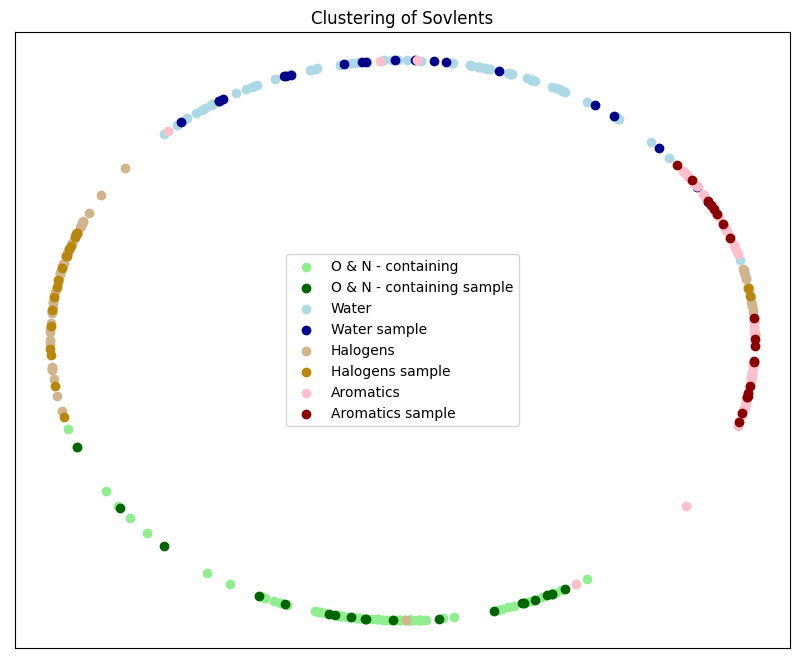

In [9]:
import math
import numpy as np
import umap
import matplotlib.pyplot as plt
import pandas as pd

color_dict = {
    'Water': 'lightblue',
    'O & N - containing':  'lightgreen',
    'Intra - molecular H - bonding': 'lightgreen',
    'Aromatics': 'pink',
    'Others': 'lavender',
    'Halogens': 'tan'
}
darker_color_dict = {
    'Water': 'darkblue',
    'O & N - containing': 'darkgreen',
    'Intra - molecular H - bonding': 'darkgreen',
    'Aromatics': 'darkred',
    'Others': 'darkpurple',
    'Halogens': 'darkgoldenrod'
}

def map_to_circle(x, y):
    """
    将二维坐标(x, y)均匀地映射到单位圆的边界上。
    """
    theta = np.arctan2(y, x)
    new_x = np.cos(theta)
    new_y = np.sin(theta)
    return new_x, new_y

def plot_circle(csv_file_path, result, feats, num):
    # 读取CSV文件数据
    df = pd.read_csv(csv_file_path)
    smiles_list = df.iloc[:, 1].tolist()  # 获取第二列（分子SMILES表示）的数据列表

    # 用于记录已经出现过的分子的字典
    seen_molecules = {}
    all_feats = []
    labels = []
    count_per_category = {category: 0 for category in result.keys()}  # 记录每个类别已添加的数量
    for category, indices in result.items():
        if category != 'Others' and category != 'Intra - molecular H - bonding':
            for idx in indices:
                molecule_smiles = smiles_list[idx]
                if molecule_smiles not in seen_molecules and count_per_category[category] < num:
                    seen_molecules[molecule_smiles] = True
                    all_feats.append(feats[idx])
                    labels.append(category)
                    count_per_category[category] += 1

    # 将特征转换为numpy数组
    all_feats = np.array(all_feats)
    print(len(all_feats))
    # 使用UMAP进行降维
    reducer = umap.UMAP(n_neighbors=30, min_dist=1)
    embedding = reducer.fit_transform(all_feats)
    # 绘制降维图
    plt.figure(figsize=(10, 8))
    # unique_categories = set(labels)
    unique_categories = ['O & N - containing', 'Water', 'Halogens', 'Aromatics']
    print(unique_categories)

    all_labels = []
    all_x = []
    all_y = []

    for category in unique_categories:
        idx = [j for j, label in enumerate(labels) if label == category]
        print(len(idx))
        np.random.shuffle(idx)
        idx_20 = idx[:20]
        idx_remain = [i for i in idx if i not in idx_20]
        if len(idx_remain) > 0:
            # 对剩下的点的坐标进行转换并绘制
            x_remain = embedding[idx_remain, 0]
            y_remain = embedding[idx_remain, 1]
            new_x_remain, new_y_remain = map_to_circle(x_remain, y_remain)
            plt.scatter(new_x_remain, new_y_remain, c=color_dict[category], label=category)
            all_labels.extend([category] * len(idx_remain))
            all_x.extend(new_x_remain)
            all_y.extend(new_y_remain)
        if len(idx_20) > 0:
            # 对深色绘制的20个点的坐标进行转换并绘制
            x_20 = embedding[idx_20, 0]
            y_20 = embedding[idx_20, 1]
            new_x_20, new_y_20 = map_to_circle(x_20, y_20)
            plt.scatter(new_x_20, new_y_20, c=darker_color_dict[category], label=category + " sample")
            all_labels.extend([category + " sample"] * len(idx_20))
            all_x.extend(new_x_20)
            all_y.extend(new_y_20)

    plt.legend()
    plt.title("Clustering of Sovlents")
    # 隐藏坐标轴
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.savefig('Clustering_of_Sovlents.pdf', bbox_inches='tight')
    plt.show()

    # 导出点的标签和坐标到CSV文件
    data = {
        'Label': all_labels,
        'X': all_x,
        'Y': all_y
    }
    df_export = pd.DataFrame(data)
    df_export.to_csv('points_coordinates.csv', index=False)


plot_circle(filepath, res_dic, feats, num=100)

In [10]:
Molca_MAE=[1.554660466,0.622027202,0.494190699,0.640542146]
GNN_MAE=[1.8653433,1.053423,0.66325532,0.675632443]
One_hot_MAE=[2.642413433,1.65344234,0.8634823,0.71323451]
Random_MAE=[2.97321342,1.6765201,1.158324323,0.721354351]
labels=['Molca','GNN','One-hot','Random']
Training_set_utilization_rate=['20%','40%','60%','80%']


In [ ]:
import matplotlib.pyplot as plt
bar_width = 0.2


# 设置x轴位置
x = range(len(Training_set_utilization_rate))


# 浅色调且不鲜艳的颜色
colors = ['#D3D3D3', '#98FB98', '#ADD8E6', '#F4A477']


# 绘制柱状图

plt.bar([i + bar_width * 1.5 for i in x], Random_MAE, width=bar_width, label=labels[3], color=colors[3])
plt.bar([i + bar_width / 2 for i in x], One_hot_MAE, width=bar_width, label=labels[2], color=colors[2])
plt.bar([i - bar_width / 2 for i in x], GNN_MAE, width=bar_width, label=labels[1], color=colors[1])
plt.bar([i - bar_width * 1.5 for i in x], Molca_MAE, width=bar_width, label=labels[0], color=colors[0])


# 设置x轴刻度和标签
plt.xticks(x, Training_set_utilization_rate)


# 设置标题和坐标轴标签
plt.xlabel('Training_set_utilization_rate')
plt.ylabel('MAE')


# 显示图例
plt.legend()
plt.savefig('Ablation experiment.pdf', bbox_inches='tight')

# 显示图形
plt.show()

In [1]:
Training_set_utilization_rate=['20%','40%','60%','80%','100%']
labels=['SSG','Systematic_Sampling','Random_Sampling']
Abraham_SSG	=[0.416976722,0.307968632,0.218535193,0.169314184,0.1381]
Compsol_SSG	=[0.402988629,0.249565379,0.193863448,0.16046071,0.1757]
Freesolv_SSG=[1.554660466,0.622027202,0.494190699,0.580542146,0.5307]
mnsol_SSG=[1.016137333,0.717336967,0.573573099,0.377605764,0.3527]
Abraham_Systematic_Sampling=[0.4586743942, 0.3387654952, 0.2403887123, 0.1862456024, 0.15191]
Compsol_Systematic_Sampling=[0.4432874919, 0.2745219169, 0.2132497928, 0.176506781, 0.19327]
Freesolv_Systematic_Sampling=[1.8655925592, 0.7464326424, 0.5930288388, 0.6966505752, 0.63684]
mnsol_Systematic_Sampling= [1.2193647996, 0.8608043604, 0.6882877188, 0.4531269168, 0.42324]
Abraham_Random_Sampling= [0.52747555333, 0.44040014376, 0.300485890375, 0.24211928312, 0.2049785]
Compsol_Random_Sampling= [0.510780615685, 0.360384592035, 0.27722473064, 0.2304588153, 0.251251]
Freesolv_Random_Sampling= [2.8003888388, 1.1196489636, 0.8895432582, 1.0449758628, 0.95526]
mnsol_Random_Sampling=  [1.40226951954, 1.11904566852, 0.89477403454, 0.58906499184, 0.550212]

In [10]:
import pandas as pd

# 定义数据
Training_set_utilization_rate = ['20%', '40%', '60%', '80%', '100%']
labels = ['SSG', 'Systematic_Sampling', 'Random_Sampling']
Abraham_SSG = [0.416976722, 0.307968632, 0.218535193, 0.169314184, 0.1381]
Compsol_SSG = [0.402988629, 0.249565379, 0.193863448, 0.16046071, 0.1757]
Freesolv_SSG = [1.554660466, 0.622027202, 0.494190699, 0.580542146, 0.5307]
mnsol_SSG = [1.016137333, 0.717336967, 0.573573099, 0.377605764, 0.3527]
Abraham_Systematic_Sampling = [0.4586743942, 0.3387654952, 0.2403887123, 0.1862456024, 0.15191]
Compsol_Systematic_Sampling = [0.4432874919, 0.2745219169, 0.2132497928, 0.176506781, 0.19327]
Freesolv_Systematic_Sampling = [1.8655925592, 0.7464326424, 0.5930288388, 0.6966505752, 0.63684]
mnsol_Systematic_Sampling = [1.2193647996, 0.8608043604, 0.6882877188, 0.4531269168, 0.42324]
Abraham_Random_Sampling = [0.52747555333, 0.44040014376, 0.300485890375, 0.24211928312, 0.2049785]
Compsol_Random_Sampling = [0.510780615685, 0.360384592035, 0.27722473064, 0.2304588153, 0.251251]
Freesolv_Random_Sampling = [2.8003888388, 1.1196489636, 0.8895432582, 1.0449758628, 0.95526]
mnsol_Random_Sampling = [1.40226951954, 1.11904566852, 0.89477403454, 0.58906499184, 0.550212]

# 构建每个数据集的 DataFrame
Abraham_data = {
    'Training_set_utilization_rate': Training_set_utilization_rate,
    'SSG': Abraham_SSG,
    'Systematic_Sampling': Abraham_Systematic_Sampling,
    'Random_Sampling': Abraham_Random_Sampling
}
Abraham_df = pd.DataFrame(Abraham_data)

Compsol_data = {
    'Training_set_utilization_rate': Training_set_utilization_rate,
    'SSG': Compsol_SSG,
    'Systematic_Sampling': Compsol_Systematic_Sampling,
    'Random_Sampling': Compsol_Random_Sampling
}
Compsol_df = pd.DataFrame(Compsol_data)

Freesolv_data = {
    'Training_set_utilization_rate': Training_set_utilization_rate,
    'SSG': Freesolv_SSG,
    'Systematic_Sampling': Freesolv_Systematic_Sampling,
    'Random_Sampling': Freesolv_Random_Sampling
}
Freesolv_df = pd.DataFrame(Freesolv_data)

mnsol_data = {
    'Training_set_utilization_rate': Training_set_utilization_rate,
    'SSG': mnsol_SSG,
    'Systematic_Sampling': mnsol_Systematic_Sampling,
    'Random_Sampling': mnsol_Random_Sampling
}
mnsol_df = pd.DataFrame(mnsol_data)

# 导出为 CSV 文件
Abraham_df.to_csv('Abraham.csv', index=False)
Compsol_df.to_csv('Compsol.csv', index=False)
Freesolv_df.to_csv('Freesolv.csv', index=False)
mnsol_df.to_csv('mnsol.csv', index=False)